In [138]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e3/sample_submission.csv
/kaggle/input/playground-series-s4e3/train.csv
/kaggle/input/playground-series-s4e3/test.csv


# Multi Label Classification

### In Multi label classification, every row can correspond to multiple classes

## Import libraries

In [139]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import early_stopping,log_evaluation, Dataset
import lightgbm as lgb
import optuna
from sklearn.preprocessing import PolynomialFeatures,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import optuna
from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import accuracy_score
import joblib
import pickle
from optuna.samplers import TPESampler

## Exploratory data analysis

In [140]:
data = pd.read_csv('/kaggle/input/playground-series-s4e3/train.csv',low_memory=False)
test = pd.read_csv('/kaggle/input/playground-series-s4e3/test.csv',low_memory=False)

In [141]:
data.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,584,590,909972,909977,16,8,5,2274,113,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,1,808,816,728350,728372,433,20,54,44478,70,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,3,781,789,3353146,3353173,210,16,29,3202,114,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,4,1540,1560,618457,618502,521,72,67,48231,82,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


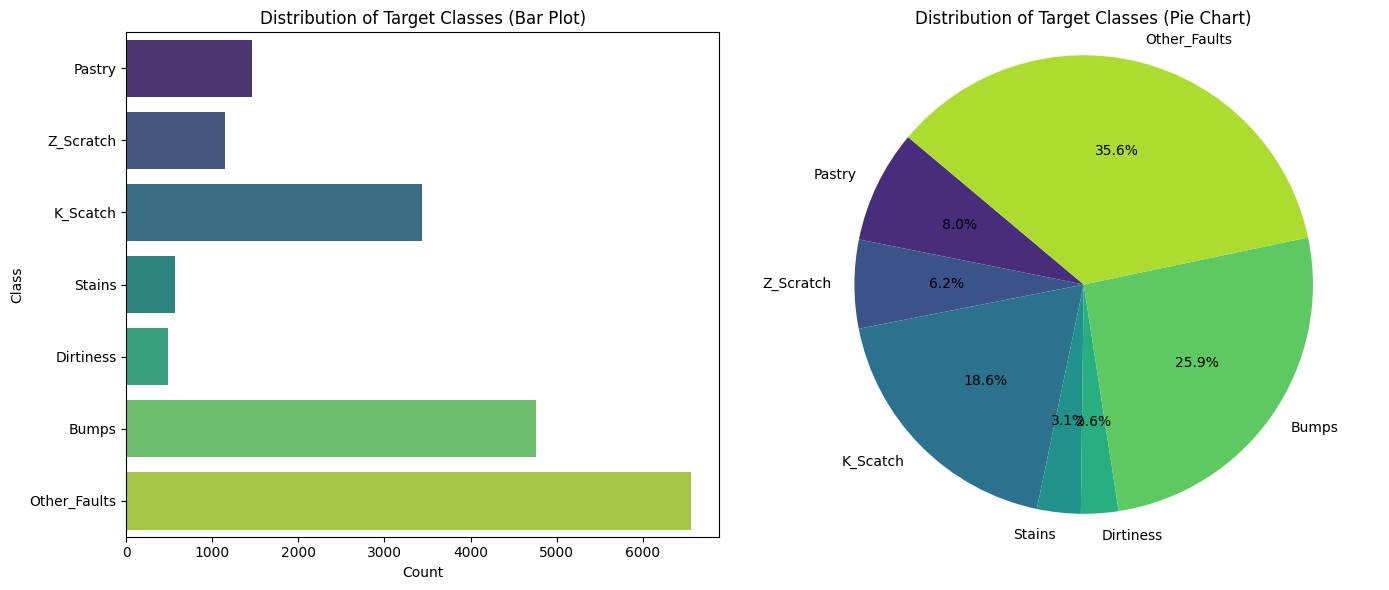

In [142]:
# data.dtypes no strings
# data.isnull().sum() zero nan values
# data.duplicated().sum() bo duplicate rows

# Visualize the distribution of each target class
target = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
target_counts = data[target].sum()

# Define color palette
colors = sns.color_palette('viridis', len(target))

# Plot horizontal bar plot
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(y=target_counts.index, x=target_counts.values, palette=colors)
plt.title('Distribution of Target Classes (Bar Plot)')
plt.xlabel('Count')
plt.ylabel('Class')

# Plot pie chart
plt.subplot(1, 2, 2)
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', colors=colors, startangle=140)
plt.axis('equal')
plt.title('Distribution of Target Classes (Pie Chart)')

plt.tight_layout()
plt.show()


## Feature generator

### We generate additional features basd off of prexisting features to help our models find more patterns in the data

In [143]:
def preprocess_data(data):
    epsilon = 1e-6  # A small constant to avoid division by zero or taking the logarithm of zero
    # Location Features
    data['X_Distance'] = data['X_Maximum'] - data['X_Minimum']
    data['Y_Distance'] = data['Y_Maximum'] - data['Y_Minimum']

    # Density Feature
    data['Density'] = data['Pixels_Areas'] / (data['X_Perimeter'] + data['Y_Perimeter'])

    # Relative Perimeter Feature
    data['Relative_Perimeter'] = data['X_Perimeter'] / (data['X_Perimeter'] + data['Y_Perimeter'] + epsilon)

    # Circularity Feature
    data['Circularity'] = data['Pixels_Areas'] / (data['X_Perimeter'] ** 2)

    # Symmetry Index Feature
    data['Symmetry_Index'] = np.abs(data['X_Distance'] - data['Y_Distance']) / (data['X_Distance'] + data['Y_Distance'] + epsilon)
    
    # Color Contrast Feature
    data['Color_Contrast'] = data['Maximum_of_Luminosity'] - data['Minimum_of_Luminosity']

    # Combined Geometric Index Feature
    data['Combined_Geometric_Index'] = data['Edges_Index'] * data['Square_Index']

    # Interaction Term Feature
    data['X_Distance*Pixels_Areas'] = data['X_Distance'] * data['Pixels_Areas']

    # Additional Features
    data['sin_orientation'] = np.sin(data['Orientation_Index'])
    data['Edges_Index2'] = np.exp(data['Edges_Index'] + epsilon)
    data['X_Maximum2'] = np.sin(data['X_Maximum'])
    data['Y_Minimum2'] = np.sin(data['Y_Minimum'])
    data['Aspect_Ratio_Pixels'] = np.where(data['Y_Perimeter'] == 0, 0, data['X_Perimeter'] / data['Y_Perimeter'])
    data['Aspect_Ratio'] = np.where(data['Y_Distance'] == 0, 0, data['X_Distance'] / data['Y_Distance'])

    # Average Luminosity Feature
    data['Average_Luminosity'] = (data['Sum_of_Luminosity'] + data['Minimum_of_Luminosity']) / 2
    
    # Normalized Steel Thickness Feature
    data['Normalized_Steel_Thickness'] = (data['Steel_Plate_Thickness'] - data['Steel_Plate_Thickness'].min()) / (data['Steel_Plate_Thickness'].max() - data['Steel_Plate_Thickness'].min())

    # Logarithmic Features
    data['Log_Perimeter'] = np.log(data['X_Perimeter'] + data['Y_Perimeter'] + epsilon)
    data['Log_Luminosity'] = np.log(data['Sum_of_Luminosity'] + epsilon)
    data['Log_Aspect_Ratio'] = np.log(data['Aspect_Ratio'] ** 2 + epsilon)

    # Statistical Features
    data['Combined_Index'] = data['Orientation_Index'] * data['Luminosity_Index']
    data['Sigmoid_Areas'] = 1 / (1 + np.exp(-data['LogOfAreas'] + epsilon))

    return data

data = preprocess_data(data)
test = preprocess_data(test)

## We apply a scaler to our features

In [144]:
target = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
X = data.drop(columns=target + ['id'], axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
test = scaler.transform(test.drop(columns=['id'], axis=1))
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24, test_size=0.3)


### We create function which will plot the area under the recieving operating curve for each target

Normally AUC is used in binary classification. Since this is a multi label classification, we treat each target as a binary target

In [145]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def plot_multioutput_roc(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)

    # Compute the ROC AUC score for each target class
    roc_auc_scores = []
    for i, col in enumerate(y_test.columns):
        roc_auc_scores.append(roc_auc_score(y_test[col], y_pred_proba[i][:, 1]))

    # Plot the ROC AUC curve for each target class
    plt.figure(figsize=(8, 6))
    for i, col in enumerate(y_test.columns):
        fpr, tpr, _ = roc_curve(y_test[col], y_pred_proba[i][:, 1])
        plt.plot(fpr, tpr, label=f'Target {col} (ROC AUC = {roc_auc_scores[i]:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Target Class')
    plt.legend()
    plt.show()

### We initially create multiple models to see which model will perform best without hyper parameter tuning

### We wrap our classifiers around a MultiOutputClassifier which deals with the fact that each row could correspond to multiple target classes

In [146]:
# Define your models
svc_model = MultiOutputClassifier(SVC())
knn_model = MultiOutputClassifier(KNeighborsClassifier())
rf_model = MultiOutputClassifier(RandomForestClassifier())
gb_model = MultiOutputClassifier(GradientBoostingClassifier())
lgbm_model = MultiOutputClassifier(LGBMClassifier())
xgb_model = MultiOutputClassifier(XGBClassifier())

[LightGBM] [Info] Number of positive: 1023, number of negative: 12430
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10431
[LightGBM] [Info] Number of data points in the train set: 13453, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.076043 -> initscore=-2.497373
[LightGBM] [Info] Start training from score -2.497373
[LightGBM] [Info] Number of positive: 809, number of negative: 12644
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10431
[LightGBM] [Info] Number of data points in the train set: 13453, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.060135 -> initscore=-2.749139
[LightGBM] [Info] Start training from score -2.749139
[LightGBM] [I

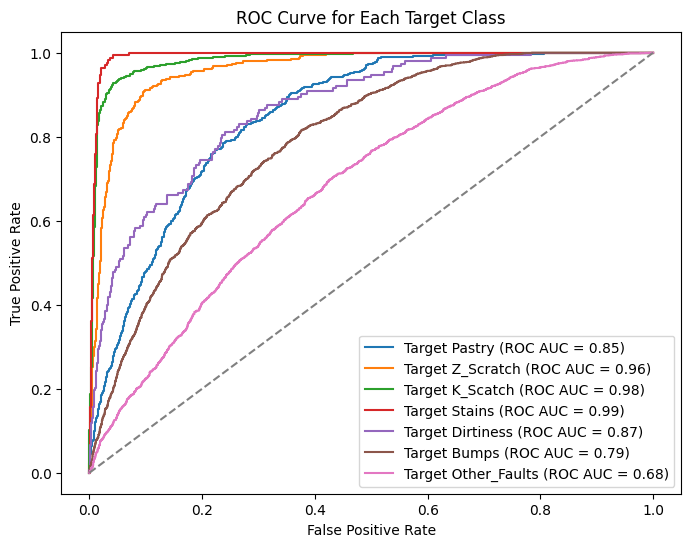

In [147]:
# Plot ROC curve for lgbm
plot_multioutput_roc(X_train, y_train, X_test, y_test, lgbm_model)

## We include a neural network

### Notice our output layer is a sigmoid function since this is multi label classification. We predict the probability of a row corresponding to one of our target classes independent on the other taregt classes

### The output of this network will be a vector of probabilities for each class, where each element represents the probability of the corresponding class being present in the input instance.

### We train our neural network using the Adam optimizer. Our Loss function is binary cross entropy

The binary cross-entropy loss function is given by:

$$
L(y, \hat{y}) = -\frac{1}{N} \sum_{i=1}^{N} \left[y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)\right]
$$

Where:
- $N$ is the number of samples.
- $y_i$ is the true label (either 0 or 1) for the \(i\)-th sample.
- $\hat{y}_i$ is the predicted probability of the positive class for the \(i\)-th sample.

We update the weights and biases through the gradient descent algorithm. We compute the partial derivative of the loss function with respect to each of the networks weights by every layer in the networl, and change the weights by the learning rate $\alpha$ in the direction such that the slope of the tangent line on the loss function will come closer to a global minimum point. We do this process 'epoch' times

$$\frac{\partial C}{\partial W} =  \frac{\partial z}{\partial W} \frac{\partial a}{\partial z} \frac{\partial C}{\partial a}$$

### Prepare my data for the network

In [148]:
device=("cuda" if torch.cuda.is_available() else "cpu")

# Convert input features to tensor
X_train_tensor = torch.tensor(np.array(X_train), dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(np.array(X_test), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(np.array(y_train), dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(np.array(y_test), dtype=torch.float32).to(device)


In [149]:
train_dataset=TensorDataset(X_train_tensor,y_train_tensor)
test_dataset=TensorDataset(X_val_tensor,y_val_tensor)
train_loader=DataLoader(train_dataset,batch_size=256)
test_loader=DataLoader(test_dataset,batch_size=256)

In [150]:
input_size = X.shape[1]
num_classes = len(target)
hidden_size = 1700

## We create a multi perceptron neural network class

Our network used GELU for experimentation to introduce non-linearity in our model. We use batch normalization to prevent overfitting. We utilize a concept called skip-connections which was introduced in the paper of the resnet.
Skip connections make the output of one layer is added to the output of a previous layer, bypassing one or more intermediate layers. These connections aim to mitigate the vanishing gradient problem and enable better flow of gradients during training, especially in deep neural networks. This has shown to create better generalization performance of this specific problem

In [151]:
class MLPBlock(nn.Module):
    def __init__(self, input_size, hidden_size, dropout):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.GELU(),  # GELU activation function
            nn.Dropout(dropout),
            nn.Linear(hidden_size, input_size),
            nn.Dropout(dropout)
        )
        self.bn = nn.BatchNorm1d(input_size)

    def forward(self, x):
        norm = self.bn(x)
        h = self.mlp(norm)
        return h + x  # Skip connection

class MLP(nn.Module):
    def __init__(self, input_size, num_blocks=6, mlp_mult=4, dropout=0.2, output_size=7):
        super().__init__()
        self.block = nn.ModuleList([MLPBlock(input_size, input_size * mlp_mult, dropout) for _ in range(num_blocks)])
        self.linear = nn.Linear(input_size, input_size)
        self.normout = nn.BatchNorm1d(input_size)
        self.out = nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.Sigmoid()  # Sigmoid activation for multi-label classification
        )

    def forward(self, x):
        proj = self.linear(x)
        for blk in self.block:
            proj = blk(proj)
        rep = self.normout(proj)
        return self.out(rep)

### We define the training function

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch 1: 100%|██████████| 53/53 [00:01<00:00, 50.55batch/s, loss=0.553]


Adjusting learning rate of group 0 to 9.9994e-04.


Epoch 2: 100%|██████████| 53/53 [00:00<00:00, 88.67batch/s, loss=0.431]


Adjusting learning rate of group 0 to 9.9975e-04.


Epoch 3: 100%|██████████| 53/53 [00:00<00:00, 90.35batch/s, loss=0.312]


Adjusting learning rate of group 0 to 9.9944e-04.


Epoch 4: 100%|██████████| 53/53 [00:00<00:00, 89.01batch/s, loss=0.263]


Adjusting learning rate of group 0 to 9.9901e-04.


Epoch 5: 100%|██████████| 53/53 [00:00<00:00, 90.08batch/s, loss=0.25] 


Adjusting learning rate of group 0 to 9.9846e-04.


Epoch 6: 100%|██████████| 53/53 [00:00<00:00, 90.01batch/s, loss=0.243]


Adjusting learning rate of group 0 to 9.9778e-04.


Epoch 7: 100%|██████████| 53/53 [00:00<00:00, 89.89batch/s, loss=0.242]


Adjusting learning rate of group 0 to 9.9698e-04.


Epoch 8: 100%|██████████| 53/53 [00:00<00:00, 87.70batch/s, loss=0.238]


Adjusting learning rate of group 0 to 9.9606e-04.


Epoch 9: 100%|██████████| 53/53 [00:00<00:00, 88.07batch/s, loss=0.232]


Adjusting learning rate of group 0 to 9.9501e-04.


Epoch 10: 100%|██████████| 53/53 [00:00<00:00, 89.77batch/s, loss=0.226]


Adjusting learning rate of group 0 to 9.9384e-04.


Epoch 11: 100%|██████████| 53/53 [00:00<00:00, 83.64batch/s, loss=0.227]


Adjusting learning rate of group 0 to 9.9255e-04.


Epoch 12: 100%|██████████| 53/53 [00:00<00:00, 84.64batch/s, loss=0.225]


Adjusting learning rate of group 0 to 9.9114e-04.


Epoch 13: 100%|██████████| 53/53 [00:00<00:00, 85.74batch/s, loss=0.224]


Adjusting learning rate of group 0 to 9.8961e-04.


Epoch 14: 100%|██████████| 53/53 [00:00<00:00, 87.58batch/s, loss=0.23] 


Adjusting learning rate of group 0 to 9.8796e-04.


Epoch 15: 100%|██████████| 53/53 [00:00<00:00, 76.08batch/s, loss=0.224]


Adjusting learning rate of group 0 to 9.8618e-04.


Epoch 16: 100%|██████████| 53/53 [00:00<00:00, 87.06batch/s, loss=0.218]


Adjusting learning rate of group 0 to 9.8429e-04.


Epoch 17: 100%|██████████| 53/53 [00:00<00:00, 88.35batch/s, loss=0.219]


Adjusting learning rate of group 0 to 9.8228e-04.


Epoch 18: 100%|██████████| 53/53 [00:00<00:00, 80.18batch/s, loss=0.22] 


Adjusting learning rate of group 0 to 9.8015e-04.


Epoch 19: 100%|██████████| 53/53 [00:00<00:00, 84.25batch/s, loss=0.218]


Adjusting learning rate of group 0 to 9.7790e-04.


Epoch 20: 100%|██████████| 53/53 [00:00<00:00, 90.61batch/s, loss=0.218]


Adjusting learning rate of group 0 to 9.7553e-04.


Epoch 21: 100%|██████████| 53/53 [00:00<00:00, 87.69batch/s, loss=0.216]


Adjusting learning rate of group 0 to 9.7304e-04.


Epoch 22: 100%|██████████| 53/53 [00:00<00:00, 90.51batch/s, loss=0.216]


Adjusting learning rate of group 0 to 9.7044e-04.


Epoch 23: 100%|██████████| 53/53 [00:00<00:00, 85.78batch/s, loss=0.218]


Adjusting learning rate of group 0 to 9.6772e-04.


Epoch 24: 100%|██████████| 53/53 [00:00<00:00, 89.88batch/s, loss=0.212]


Adjusting learning rate of group 0 to 9.6489e-04.


Epoch 25: 100%|██████████| 53/53 [00:00<00:00, 82.13batch/s, loss=0.214]


Adjusting learning rate of group 0 to 9.6194e-04.


Epoch 26: 100%|██████████| 53/53 [00:00<00:00, 81.45batch/s, loss=0.212]


Adjusting learning rate of group 0 to 9.5888e-04.


Epoch 27: 100%|██████████| 53/53 [00:00<00:00, 82.08batch/s, loss=0.212]


Adjusting learning rate of group 0 to 9.5570e-04.


Epoch 28: 100%|██████████| 53/53 [00:00<00:00, 85.84batch/s, loss=0.215]


Adjusting learning rate of group 0 to 9.5241e-04.


Epoch 29: 100%|██████████| 53/53 [00:00<00:00, 89.79batch/s, loss=0.211]


Adjusting learning rate of group 0 to 9.4901e-04.


Epoch 30: 100%|██████████| 53/53 [00:00<00:00, 89.12batch/s, loss=0.21] 


Adjusting learning rate of group 0 to 9.4550e-04.


Epoch 31: 100%|██████████| 53/53 [00:00<00:00, 90.07batch/s, loss=0.209]


Adjusting learning rate of group 0 to 9.4188e-04.


Epoch 32: 100%|██████████| 53/53 [00:00<00:00, 89.22batch/s, loss=0.209]


Adjusting learning rate of group 0 to 9.3815e-04.


Epoch 33: 100%|██████████| 53/53 [00:00<00:00, 89.95batch/s, loss=0.208]


Adjusting learning rate of group 0 to 9.3432e-04.


Epoch 34: 100%|██████████| 53/53 [00:00<00:00, 83.78batch/s, loss=0.202]


Adjusting learning rate of group 0 to 9.3037e-04.


Epoch 35: 100%|██████████| 53/53 [00:00<00:00, 80.37batch/s, loss=0.2]  


Adjusting learning rate of group 0 to 9.2632e-04.


Epoch 36: 100%|██████████| 53/53 [00:00<00:00, 86.77batch/s, loss=0.205]


Adjusting learning rate of group 0 to 9.2216e-04.


Epoch 37: 100%|██████████| 53/53 [00:00<00:00, 87.22batch/s, loss=0.202]


Adjusting learning rate of group 0 to 9.1790e-04.


Epoch 38: 100%|██████████| 53/53 [00:00<00:00, 88.45batch/s, loss=0.201]


Adjusting learning rate of group 0 to 9.1354e-04.
Early stopping after 38 epochs with no improvement.


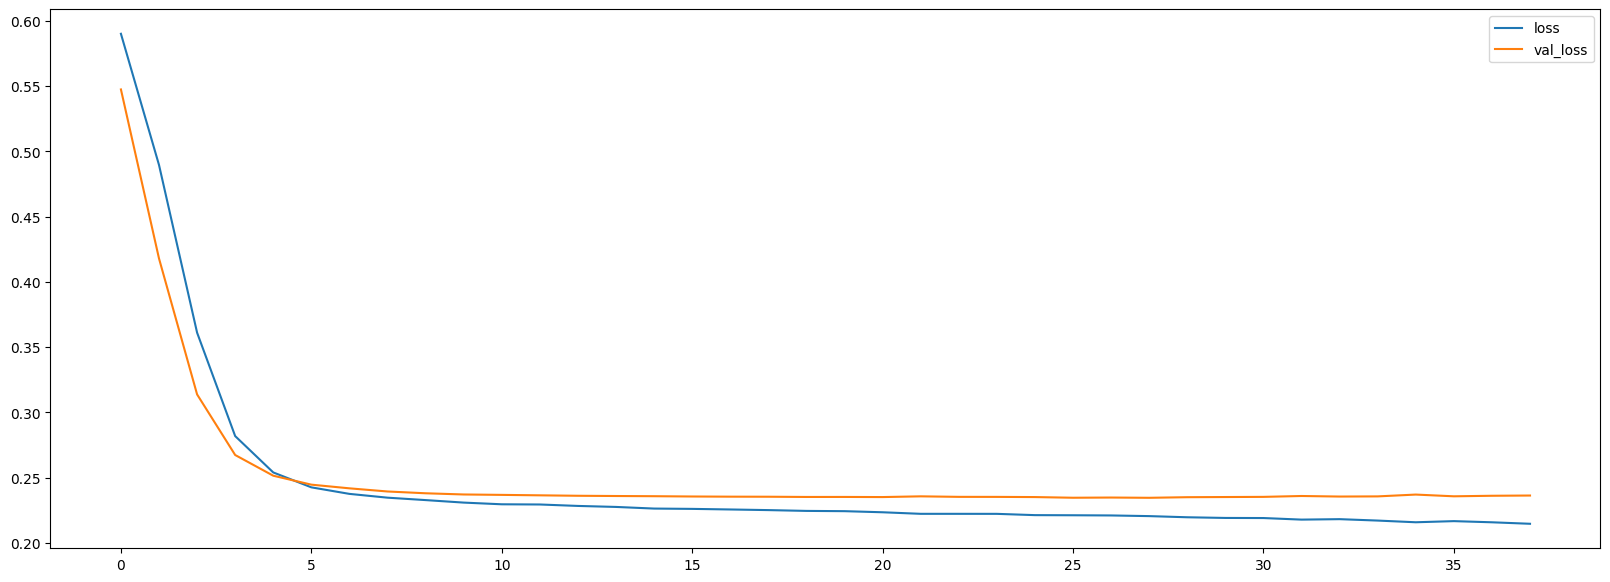

Test ROC Score:  0.8704385889127634


In [152]:
import tqdm
from sklearn.metrics import roc_auc_score
from torch.optim.lr_scheduler import CosineAnnealingLR

class Trainer:
    def __init__(self, model, loss_fn, optimizer, scheduler=None):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.history = {'losses': [], 'val_losses': []}

    def fit(self, train_loader, val_loader, epochs, verbose=1, patience=None):
        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(1, epochs + 1):
            self.model.train()
            train_losses = []

            with tqdm.tqdm(train_loader, unit="batch", mininterval=0, disable=(not verbose)) as bar:
                bar.set_description(f"Epoch {epoch}")
                for X_batch, y_batch in bar:
                    self.optimizer.zero_grad()
                    y_pred = self.model(X_batch)
                    loss = self.loss_fn(y_pred, y_batch)
                    loss.backward()
                    self.optimizer.step()

                    train_losses.append(loss.item())
                    bar.set_postfix(loss=float(loss))

                avg_train_loss = sum(train_losses) / len(train_losses)
                self.history['losses'].append(avg_train_loss)

                # Validation
                self.model.eval()
                val_losses = []

                with torch.no_grad():
                    for X_val, y_val in val_loader:
                        y_pred_val = self.model(X_val)
                        val_loss = self.loss_fn(y_pred_val, y_val)
                        val_losses.append(val_loss.item())

                avg_val_loss = sum(val_losses) / len(val_losses)
                self.history['val_losses'].append(avg_val_loss)

                # Update learning rate if scheduler is provided
                if self.scheduler is not None:
                    self.scheduler.step()

                # Early stopping
                if patience is not None:
                    if avg_val_loss < best_val_loss:
                        best_val_loss = avg_val_loss
                        patience_counter = 0
                    else:
                        patience_counter += 1

                    if patience_counter >= patience:
                        print(f"Early stopping after {epoch} epochs with no improvement.")
                        break

        return self.history

# Create model, optimizer, scheduler
neural_model = MLP(input_size=X.shape[1], num_blocks=6, mlp_mult=4, dropout=0.2, output_size=len(target))
neural_model.to(device)
optimizer = torch.optim.Adam(neural_model.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=200, verbose=True)

# Wrap the model, loss, optimizer, and scheduler in Trainer
trainer = Trainer(neural_model, nn.BCELoss(), optimizer, scheduler)

# Fit the model using Trainer
history = trainer.fit(train_loader, test_loader, epochs=200, verbose=1, patience=10)

# Plot the training history
plt.figure(figsize=(20, 7))
plt.plot(range(len(history['losses'])), history['losses'])
plt.plot(range(len(history['val_losses'])), history['val_losses'])
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

# Make predictions on the test set
neural_model.eval()
with torch.no_grad():
    y_pred_val = neural_model(X_val_tensor).cpu().numpy()

test_score = roc_auc_score(y_val_tensor.cpu().numpy(), y_pred_val)
print('Test ROC Score: ', test_score)

In [153]:
# Save the model
torch.save(neural_model.state_dict(), 'neural_model.pth')

In [154]:
# Load the model
# model = Network()  # Create an instance of your model class
# model.load_state_dict(torch.load('model.pth'))
# model.eval()  # Set the model to evaluation mode after loading

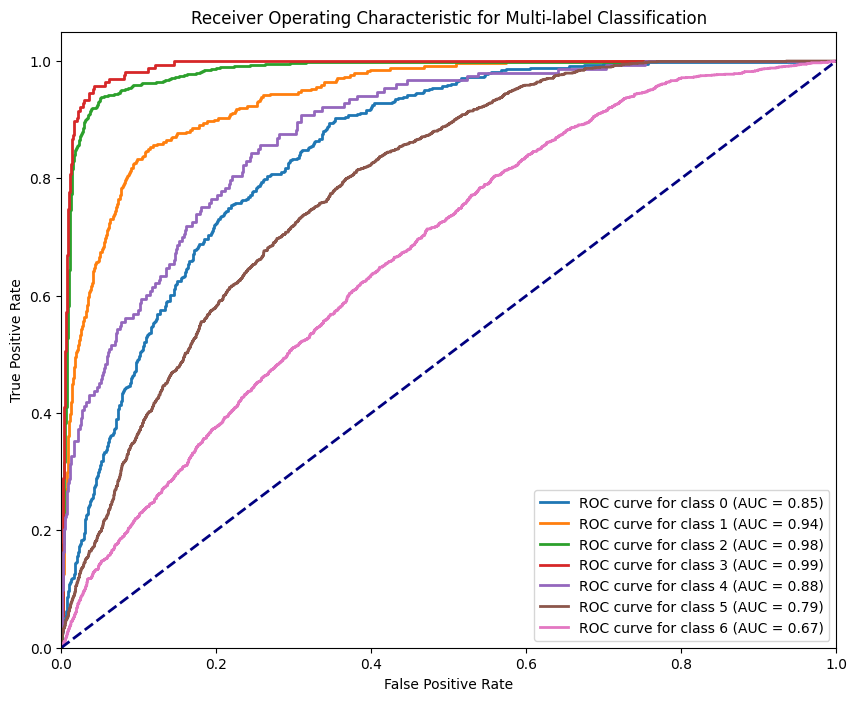

In [155]:
# Make predictions on the validation set
neural_model.eval()
with torch.no_grad():
    y_pred_val = neural_model(X_val_tensor).cpu().numpy()

# Convert y_val_tensor to a numpy array
y_val_np = y_val_tensor.cpu().numpy()

# Compute the ROC curve and AUC for each target class
plt.figure(figsize=(10, 8))
for i in range(y_pred_val.shape[1]):
    fpr, tpr, thresholds = roc_curve(y_val_np[:, i], y_pred_val[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label='ROC curve for class {} (AUC = {:.2f})'.format(i, roc_auc))

# Plot the random guessing line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot attributes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-label Classification')
plt.legend(loc="lower right")
plt.show()


# Stacking
### In stacking we combine the predictions from various models, by using the predictions as paraemters in a neural network

## We start by using optuna for hyperparameter tuning for each of our boosting algorithms

In [156]:
# Define the objective function
def objective_cat(trial):
    # Define the search space for CatBoost hyperparameters
    cat_params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'depth': trial.suggest_int('depth', 1, 10),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.05, 1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100)
    }
    cat_model = MultiOutputClassifier(CatBoostClassifier(**cat_params, silent=True))
    cat_model.fit(X_train, y_train)
    cat_predictions = cat_model.predict(X_test)
    cat_accuracy = roc_auc_score(y_test, cat_predictions,)
    return cat_accuracy

study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=30)

# Define the best hyperparameters obtained from Optuna
best_params_cat = study_cat.best_params

# Instantiate CatBoostClassifier with the best hyperparameters
best_cat_model = MultiOutputClassifier(CatBoostClassifier(**best_params_cat, silent=True))

# Fit the model on the training data
best_cat_model.fit(X_train, y_train)

# Obtain accuracy score
y_pred_cat = best_cat_model.predict(X_test)
roc_auc_score(y_test, y_pred_cat)

# Save the trained model
joblib.dump(best_cat_model, 'best_cat_model.pkl')

[I 2024-03-11 13:15:38,307] A new study created in memory with name: no-name-63317305-ef87-44a5-928e-f7d7701e55ad
/tmp/ipykernel_34/1736177739.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
[I 2024-03-11 13:15:53,922] Trial 0 finished with value: 0.685367928504439 and parameters: {'iterations': 229, 'learning_rate': 0.02834469528463488, 'depth': 5, 'colsample_bylevel': 0.8753680878567024, 'min_data_in_leaf': 58}. Best is trial 0 with value: 0.685367928504439.
/tmp/ipykernel_34/1736177739.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate

['best_cat_model.pkl']

In [162]:
def objective_xgb(trial):
    params = {
        "objective": "multi:softmax",
        "num_class": 7,
        "n_estimators": 1000,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "eval_metric": 'merror',
    }

    model_xgb = MultiOutputClassifier(xgb.XGBClassifier(**params))
    model_xgb.fit(X_train, y_train, verbose=False)
    predictions_xgb = model_xgb.predict(X_test)
    accuracy_xgb = roc_auc_score(y_test, predictions_xgb)
    return accuracy_xgb

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=30)
print('Best hyperparameters:', study_xgb.best_params)
print('Best accuracy:', study_xgb.best_value)

# Define the best hyperparameters obtained from Optuna
best_params_xgb = study_xgb.best_params

# Instantiate CatBoostClassifier with the best hyperparameters
best_xgb_model = MultiOutputClassifier(xgb.XGBClassifier(**best_params_xgb, silent=True))

# Fit the model on the training data
best_xgb_model.fit(X_train, y_train)

# Obtain accuracy score
y_pred_xgb = best_xgb_model.predict(X_test)
roc_auc_score(y_test, y_pred_xgb)

# Save the trained model
joblib.dump(best_xgb_model, 'best_xgb_model.pkl')

[I 2024-03-11 13:56:50,686] A new study created in memory with name: no-name-ddbf2ce5-32c4-44a8-9719-e66771addb15
[I 2024-03-11 13:58:06,529] Trial 0 finished with value: 0.68150941058978 and parameters: {'learning_rate': 0.009346075322857542, 'max_depth': 4, 'subsample': 0.11730623258931543, 'min_child_weight': 13}. Best is trial 0 with value: 0.68150941058978.
[I 2024-03-11 14:00:16,398] Trial 1 finished with value: 0.6813516108266446 and parameters: {'learning_rate': 0.002927627466173377, 'max_depth': 8, 'subsample': 0.3459078979521796, 'min_child_weight': 7}. Best is trial 0 with value: 0.68150941058978.
[I 2024-03-11 14:02:01,320] Trial 2 finished with value: 0.6909511658519761 and parameters: {'learning_rate': 0.007737360343450035, 'max_depth': 6, 'subsample': 0.41595184834748816, 'min_child_weight': 10}. Best is trial 2 with value: 0.6909511658519761.
[I 2024-03-11 14:03:47,148] Trial 3 finished with value: 0.6891523688275448 and parameters: {'learning_rate': 0.01264772304080647

Best hyperparameters: {'learning_rate': 0.00839244957293117, 'max_depth': 4, 'subsample': 0.5984944828802824, 'min_child_weight': 8}
Best accuracy: 0.692938302366177


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:42:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:42:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


['best_xgb_model.pkl']

# Stacked models

In [212]:
# Move the test data to the CUDA device if available
test_tensor = torch.tensor(test, dtype=torch.float32).to(device)

# Generate predictions using the neural model
with torch.no_grad():
    neural_model.eval()  # Set the model to evaluation mode
    preds_neural = neural_model(test_tensor).cpu().numpy() 

# Generate predictions using the other models
preds_lgbm = lgbm_model.predict_proba(test)
preds_catboost = best_cat_model.predict_proba(test)
preds_xgb = best_xgb_model.predict_proba(test)

preds_lgbm = np.array([preds_lgbm])
preds_lgbm = preds_lgbm.reshape(-1, 7, 2)[:, :, 0]

preds_catboost = np.array([preds_catboost])
preds_catboost = preds_catboost.reshape(-1, 7, 2)[:, :, 0]

preds_xgb = np.array([preds_xgb])
preds_xgb = preds_xgb.reshape(-1, 7, 2)[:, :, 0]


# Combine the predictions by taking the average
preds_combined = (preds_neural + preds_xgb + preds_catboost + preds_lgbm) / 4


id_df = pd.read_csv('/kaggle/input/playground-series-s4e3/sample_submission.csv')
ids = id_df['id']

# Create the submission DataFrame
submission = pd.DataFrame(preds_neural, columns=y_train.columns)
submission.insert(0, 'id', ids)


submission.to_csv('submission.csv', index=False)

display(submission)


,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.590694,0.003248,0.001038,0.001468,0.032996,0.134437,0.343053
1,19220,0.250218,0.017584,0.007107,0.003068,0.156644,0.097159,0.439504
2,19221,0.009741,0.060436,0.043644,0.004944,0.010283,0.317578,0.458017
3,19222,0.147089,0.001537,0.000662,0.003550,0.007547,0.442269,0.393511
4,19223,0.002008,0.002539,0.001796,0.000660,0.003880,0.709173,0.315228
...,...,...,...,...,...,...,...,...
12809,32028,0.187790,0.091052,0.001799,0.000874,0.027711,0.230885,0.348738
12810,32029,0.228260,0.004939,0.007219,0.003502,0.186708,0.090836,0.446291
12811,32030,0.000226,0.000353,0.943647,0.000172,0.000197,0.000462,0.095593
12812,32031,0.502844,0.005335,0.006138,0.001460,0.052374,0.103158,0.339546
